# 5.0 10X Genomics PBMC 3K Dataset

In [1]:
from clustergrammer_widget import *
net = Network(clustergrammer_widget)
df = {}

import clustergrammer_groupby as cby
import gene_exp_10x

In [2]:
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline 

### Load Data

In [3]:
df['ge-ini'] = gene_exp_10x.load_gene_exp_to_df('../data/pbmc3k_filtered_gene_bc_matrices/hg19/')
df['ge-ini'].shape

(32738, 2700)

In [4]:
all_genes = df['ge-ini'].index.tolist()
print(len(all_genes))
keep_genes = [x for x in all_genes if 'RPL' not in x]
keep_genes = [x for x in keep_genes if 'RPS' not in x]
print(len(keep_genes))

df['ge'] = df['ge-ini'].loc[keep_genes]
df['ge'].shape

# Removing Mitochondrial Genes
list_mito_genes = ['MTRNR2L11', 'MTRF1', 'MTRNR2L12', 'MTRNR2L13', 'MTRF1L', 'MTRNR2L6', 'MTRNR2L7',
                'MTRNR2L10', 'MTRNR2L8', 'MTRNR2L5', 'MTRNR2L1', 'MTRNR2L3', 'MTRNR2L4']

all_genes = df['ge'].index.tolist()
mito_genes = [x for x in all_genes if 'MT-' == x[:3] or 
             x.split('_')[0] in list_mito_genes]
print(mito_genes)

keep_genes = [x for x in all_genes if x not in mito_genes]
df['ge'] = df['ge'].ix[keep_genes]

# normalize by UMI count
barcode_umi_sum = df['ge'].sum()
df['ge'] = df['ge'].div(barcode_umi_sum)

32738
32546
['MTRNR2L11', 'MTRNR2L12', 'MTRNR2L13', 'MTRF1L', 'MTRNR2L6', 'MTRNR2L10', 'MTRNR2L7', 'MTRNR2L5', 'MTRNR2L8', 'MTRF1', 'MTRNR2L4', 'MTRNR2L1', 'MTRNR2L3', 'MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB']


In [5]:
net.load_df(df['ge'])
net.normalize(axis='row', norm_type='zscore')
net.swap_nan_for_zero()
df['ge-z'] = net.export_df()
df['ge-z'].shape

(32520, 2700)

### Visualize Original Dataset

In [6]:
net.load_df(df['ge'])
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.clip(lower=-5, upper=5)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


### Load NM'3337 gene sigantures

In [7]:
net.load_file('../data/cell_type_signatures/nm3337_broad_cell_type_sigs.txt')
df['bct-sig'] = net.export_df()
print(df['bct-sig'].shape)

net.load_file('../data/cell_type_signatures/nm3337_narrow_cell_type_sigs.txt')
df['nct-sig'] = net.export_df()
print(df['nct-sig'].shape)

(523, 9)
(523, 22)


In [8]:
net.load_df(df['nct-sig'])
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [9]:
sig_rows = df['bct-sig'].index.tolist()
clean_sig_rows = [x.split('_')[0] for x in sig_rows]
print(len(clean_sig_rows), len(list(set(clean_sig_rows))))

523 523


In [10]:
ge_rows = df['ge'].index.tolist()
clean_ge_rows = [x.split('_')[0] for x in ge_rows]
print(len(ge_rows), len(list(set(clean_ge_rows))))

32520 32425


In [11]:
ser_ge_rows = pd.Series(clean_ge_rows)

In [12]:
gene_name_count = ser_ge_rows.value_counts(ascending=False)
duplicate_genes = gene_name_count[gene_name_count > 1].index.tolist()
len(duplicate_genes)

91

### only add unique index to duplicate genes

In [13]:
dup_index = {}
new_rows = []
for inst_row in clean_ge_rows:
    
    # add index to non-unique genes
    if inst_row in duplicate_genes:
        
        # calc non-unique index
        if inst_row not in dup_index:
            dup_index[inst_row] = 1
        else:
            dup_index[inst_row] = dup_index[inst_row]  + 1
            
        new_row = inst_row + '_' + str(dup_index[inst_row])
        
    else:
        new_row = inst_row
        
    new_rows.append(new_row)

In [14]:
print(len(new_rows))
print(len(list(set(new_rows))))

32520
32520


In [15]:
# df['ge'].index = new_rows
# df['ge-z'].index = new_rows

# Predict Cell Types using NM3337 Signatures

In [16]:
rows = df['nct-sig'].index.tolist()
new_rows = [x.split('_')[0] for x in rows]
df['nct-sig'].index = new_rows

In [17]:
df['nct-sig'].columns.tolist()

[('B cells naive', 'B cells naive'),
 ('B cells memory', 'B cells memory'),
 ('Plasma cells', 'Plasma cells'),
 ('T cells CD8', 'T cells CD8'),
 ('T cells CD4 naive', 'T cells CD4 naive'),
 ('T cells CD4 memory resting', 'T cells CD4 memory resting'),
 ('T cells CD4 memory activated', 'T cells CD4 memory activated'),
 ('T cells follicular helper', 'T cells follicular helper'),
 ('T cells regulatory (Tregs)', 'T cells regulatory (Tregs)'),
 ('T cells gamma delta', 'T cells gamma delta'),
 ('NK cells resting', 'NK cells resting'),
 ('NK cells activated', 'NK cells activated'),
 ('Monocytes', 'Monocytes'),
 ('Macrophages M0', 'Macrophages M0'),
 ('Macrophages M1', 'Macrophages M1'),
 ('Macrophages M2', 'Macrophages M2'),
 ('Dendritic cells resting', 'Dendritic cells resting'),
 ('Dendritic cells activated', 'Dendritic cells activated'),
 ('Mast cells resting', 'Mast cells resting'),
 ('Mast cells activated', 'Mast cells activated'),
 ('Eosinophils', 'Eosinophils'),
 ('Neutrophils', 'Neutr

In [18]:
rows = df['bct-sig'].index.tolist()
new_rows = [x.split('_')[0] for x in rows]
df['bct-sig'].index = new_rows

In [19]:
# rows = df['ge-z'].index.tolist()
# new_rows = [x.split('_')[0] for x in rows]
# df['ge-z'].index = new_rows

In [20]:
df['pred_cat'], df['sig_sim'], y_info = cby.predict_cats_from_sigs(df['ge-z'], df['bct-sig'], 
                                                                   predict_level='Cell Type', unknown_thresh=0.05)

In [21]:
net.load_df(df['pred_cat'])
net.set_cat_color(axis='col', cat_index=1, cat_name='Cell Type: T cells CD8', inst_color='red')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.clip(lower=-5, upper=5)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [22]:
df['ge-cat'] = deepcopy(df['ge'])
df['ge-cat'].shape

(32520, 2700)

In [23]:
# transfer predicted categories to full dataset and add UMI count
cat_cols = df['pred_cat'].columns.tolist()
df['ge-cat'].columns = cat_cols

# new_cols = [(x[0], x[1], 'UMI: ' + str(barcode_umi_sum[x[0]])) for x in cat_cols]

df['ge-cat-umi'] = deepcopy(df['ge-cat'])
# df['ge-cat-umi'].columns = new_cols
# print(df['ge-cat-umi'].shape)

In [24]:
net.load_df(df['ge-cat-umi'])
net.set_cat_color(axis='col', cat_index=1, cat_name='Cell Type: T cells CD8', inst_color='red')
net.filter_N_top(inst_rc='row', N_top=250, rank_type='var')
net.random_sample(axis='col', num_samples=250, random_state=99)
net.normalize(axis='row', norm_type='zscore')
df['tmp'] = net.export_df()
net.clip(lower=-5, upper=5)
net.cluster()
net.widget()

Widget Javascript not detected.  It may not be installed or enabled properly.


In [25]:
df['tmp'].shape

(250, 250)

# Make more general comparison

In [26]:
sim_dict, pval_dict = cby.sim_same_and_diff_category_samples(df['tmp'])

In [27]:
sim_dict['same'].mean()

0.1033134243768756

In [28]:
sim_dict['diff'].mean()

-0.024238409009971908

In [29]:
pval_dict

{'mannwhitney': 0.0, 'ttest': 0.0}

### Signature Prediction

In [30]:
%%time
net.load_df(df['ge-cat-umi'])
net.filter_N_top(inst_rc='row', N_top=1000, rank_type='var')
net.normalize(axis='row', norm_type='zscore')
df['ge-cat-umi-z'] = net.export_df() 

df['cat-sig'], keep_genes, keep_genes_dict = cby.generate_signatures(
                                                          df['ge-cat-umi-z'], 
                                                          'Cell Type', pval_cutoff=0.05)

df['pred_cat'], df['sig_sim'], y_info = cby.predict_cats_from_sigs(df['ge-cat-umi-z'], 
                                                                   df['cat-sig'])

df['conf'], populations, ser_correct, fraction_correct = cby.confusion_matrix_and_correct_series(y_info)
print('fraction correct: ', fraction_correct)
print(f1_score(y_info['true'], y_info['pred'], average='macro'))
print(f1_score(y_info['true'], y_info['pred'], average='micro'))
print(f1_score(y_info['true'], y_info['pred'], average='weighted'))

fraction correct:  0.734074074074
0.619396343163
0.734074074074
0.718106748157
CPU times: user 1.13 s, sys: 666 ms, total: 1.79 s
Wall time: 1.71 s


### Shuffle

In [35]:
%%time
num_shuffles = 10
perform_ser = cby.compare_performance_to_shuffled_labels(df['ge-cat-umi-z'], 'Cell Type', 
                                                         num_shuffles=num_shuffles)
print('mean: ', perform_ser.mean(), 'std: ', perform_ser.std())
print('previously calc real performance: ', fraction_correct)

performance (fraction correct) of unshuffled: 0.734074074074
mean:  0.3645185185185185 std:  0.02519414026219763
previously calc real performance:  0.734074074074
CPU times: user 3.54 s, sys: 779 ms, total: 4.32 s
Wall time: 4.3 s


In [36]:
perform_ser[perform_ser > fraction_correct]

Series([], dtype: float64)

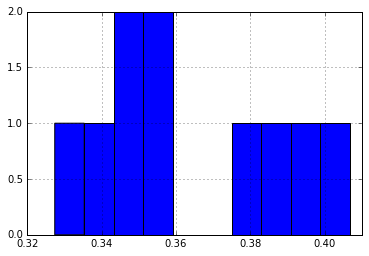

In [37]:
perform_ser.hist()

In [38]:
(fraction_correct - perform_ser.mean())/perform_ser.std()

14.668313810654322

# Same-Cat vs Diff-Cat Sample Similarity

In [115]:
net.load_df(df['ge-cat-umi-z'])
# net.random_sample(axis='col', num_samples=750, random_state=99)
df['ge-small'] = net.export_df()
print(df['ge-small'].shape)

(1000, 2700)


In [116]:
%%time
sim_dict, pval_dict = cby.sim_same_and_diff_category_samples(df['ge-small'])

CPU times: user 1min 59s, sys: 7.13 s, total: 2min 6s
Wall time: 2min 7s


### need to normalize histograms

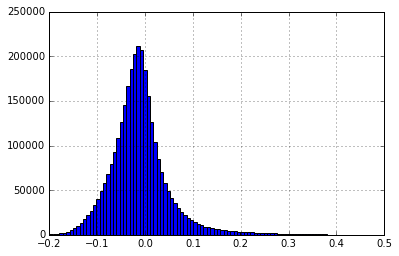

In [117]:
hist = {}
hist['diff'] = sim_dict['diff'].hist(bins=100, range=(-0.2,0.5))

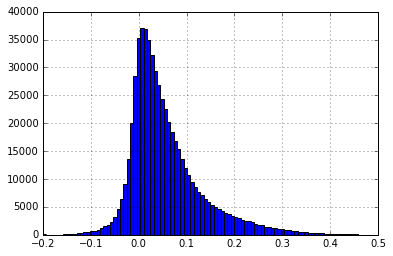

In [118]:
hist['same'] = sim_dict['same'].hist(bins=100, range=(-0.2,0.5))

In [119]:
sim_dict['diff'].mean()

-0.011174412632669054

In [120]:
sim_dict['same'].mean()

0.05650379027285602

### Calc ROC Curve

In [121]:
from sklearn.metrics import roc_curve

In [129]:
sim_dict['same'].shape

(595270,)

In [132]:
true_index = list(np.ones(sim_dict['same'].shape[0]))
false_index = list(np.zeros(sim_dict['diff'].shape[0]))
y_true = true_index + false_index
print(len(y_true))

3643650


In [133]:
true_val = list(sim_dict['same'].get_values())
false_val = list(sim_dict['diff'].get_values())
y_score = true_val + false_val
print(len(y_score))

3643650


In [135]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)

In [136]:
fpr.shape

(1361804,)

In [137]:
tpr.shape

(1361804,)

### Plot ROC Curve

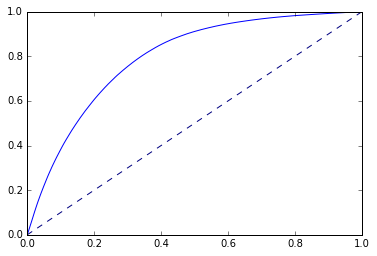

In [147]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.figure(figsize=(10,10))

In [142]:
from sklearn.metrics import auc

In [144]:
auc(fpr, tpr)

0.79334894112062815

In [143]:
hist['diff']

In [ ]:
x = range(1000)

In [63]:
np.histogram(sim_dict['diff'], )

(array([  10,   24,   51,  129,  266,  852, 4206, 8540, 2509,  224]),
 array([ -2.29156215e-03,  -1.96546486e-03,  -1.63936757e-03,
         -1.31327027e-03,  -9.87172976e-04,  -6.61075682e-04,
         -3.34978388e-04,  -8.88109303e-06,   3.17216201e-04,
          6.43313496e-04,   9.69410790e-04]))

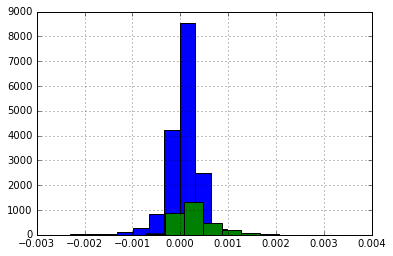

In [60]:
sim_dict['diff'].hist()
sim_dict['same'].hist()

In [57]:
print(sim_dict['diff'].sum(), sim_dict['same'].sum())

1.0000000000000067 0.9999999999999993


In [58]:
print(sim_dict['diff'].mean(), sim_dict['same'].mean())

5.948486110284972e-05 0.00032372936225315616
